0. Load the Data

In [4]:
from pandas import read_csv
df = read_csv("C:/Users/qhaskovec/OneDrive/GitHub/PhD-Thesis-EU-Solidarity-Statements/EUSpeech_translated_preprocessed.csv")

1. Descriptive Statistics

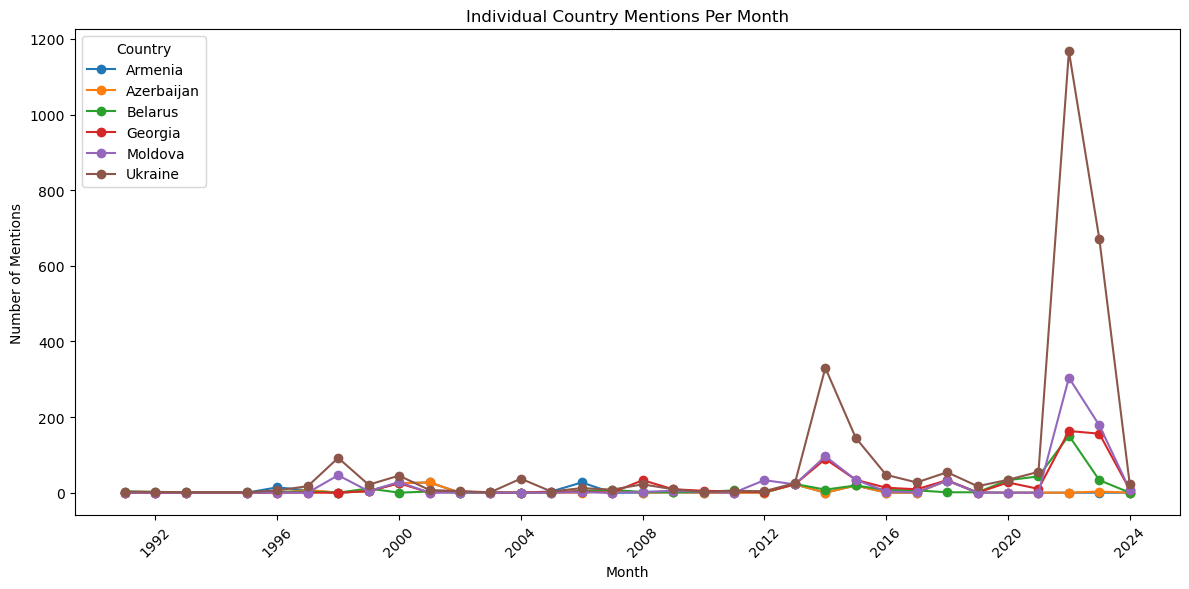

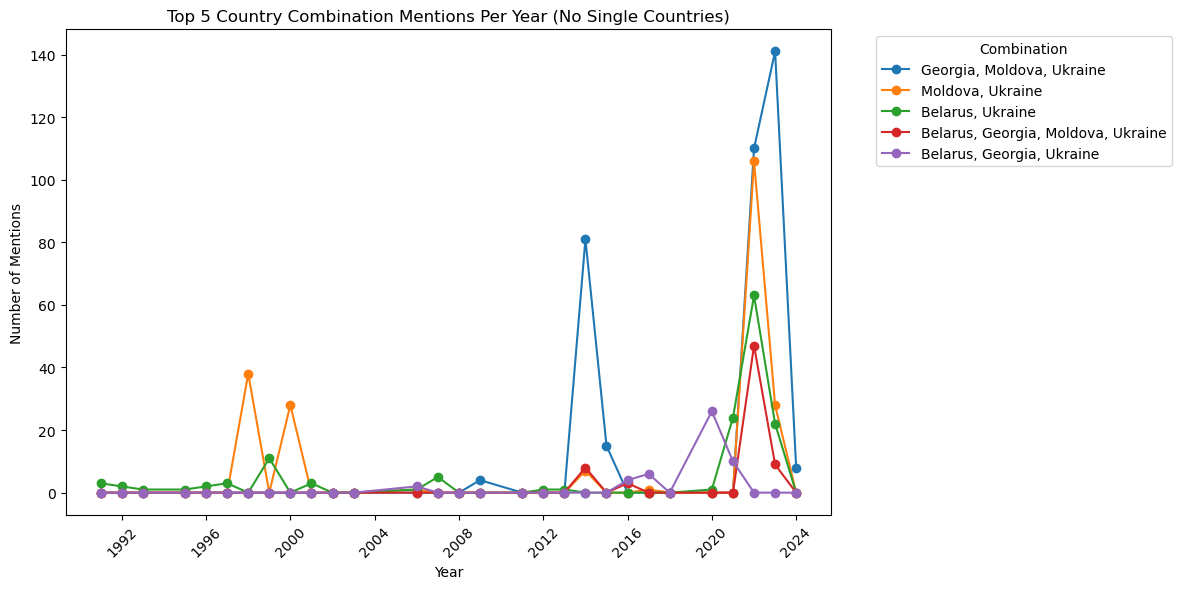

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the data ---
# Ensure that the date column is in datetime format.
df["date"] = pd.to_datetime(df["date"])

# -------------------------------
# Plot 1: Mentions of individual countries per month
# -------------------------------

# Split the "matched_keyword" string into a list and then explode to have one country per row.
df_exploded = df.copy()
df_exploded["country"] = df_exploded["matched_keyword"].str.split(r",\s*")
df_exploded = df_exploded.explode("country")

# Group by month and country.
# Using dt.to_period('M') converts the dates to monthly periods; then .dt.to_timestamp() converts it back to a datetime for plotting.
individual_counts = (
    df_exploded.groupby([df_exploded["date"].dt.to_period("Y").dt.to_timestamp(), "country"])
               .size()
               .unstack(fill_value=0)
)

# Plot each country's mentions over time (by month).
plt.figure(figsize=(12, 6))
for country in individual_counts.columns:
    plt.plot(individual_counts.index, individual_counts[country], marker="o", label=country)
plt.xlabel("Month")
plt.ylabel("Number of Mentions")
plt.title("Individual Country Mentions Per Month")
plt.xticks(rotation=45)
plt.legend(title="Country")
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Mentions of country combinations per month
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import re

# Helper function: sort the countries in the combination so that order does not matter.
def sorted_combination(matched):
    if pd.isna(matched):
        return None
    countries = [x.strip() for x in matched.split(",") if x.strip() != ""]
    if not countries:
        return None
    return ", ".join(sorted(countries))

# Create a new column for the sorted combination.
df["combination"] = df["matched_keyword"].apply(sorted_combination)

# Filter out single-country combinations (those without a comma).
df_multi = df[df["combination"].apply(lambda x: x is not None and "," in x)]

# Group by year and combination.
combination_counts = (
    df_multi.groupby([df_multi["date"].dt.to_period("Y").dt.to_timestamp(), "combination"])
          .size()
          .unstack(fill_value=0)
)

# Select the top 5 most common combinations overall.
top_combinations = combination_counts.sum().sort_values(ascending=False).head(5).index
combination_counts_top = combination_counts[top_combinations]

# Plot the top 5 combinations over time (by year).
plt.figure(figsize=(12, 6))
for combo in combination_counts_top.columns:
    plt.plot(combination_counts_top.index, combination_counts_top[combo], marker="o", label=combo)
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.title("Top 5 Country Combination Mentions Per Year (No Single Countries)")
plt.xticks(rotation=45)
plt.legend(title="Combination", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


